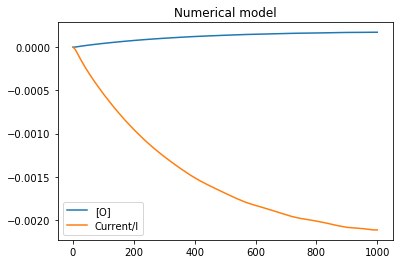

In [23]:
from hh_markov_model import ChannelModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate


# Run the numerical model

t = 1000
params = [2.26E-04, 0.0699, 3.45E-05, 0.05462, 0.0873, 8.92E-03, 5.150E-3, 0.03158, 0.1524]
model = ChannelModel(params, lambda t: -80)
initial_conditions = model.getStates(0)
solution = integrate.solve_ivp(model.getDerivatives, [0,t], model.getStates(0))

y = solution.y
IVec = [model.calculateCurrent(y[0,t], y[1,t], y[2,t]) for t in range(0,len(solution.t))]

plt.plot(solution.t, solution.y[1])
plt.plot(solution.t, IVec)
plt.legend(["[O]", "Current/I"])
plt.title("Numerical solution")
plt.xlabel("time /s")
plt.show()

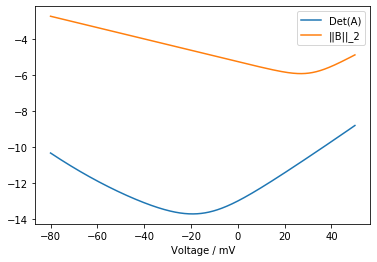

In [24]:
params = [2.26E-04, 0.0699, 3.45E-05, 0.05462, 0.0873, 8.92E-03, 5.150E-3, 0.03158, 0.1524]
dets = []
norms =[]

volts = np.linspace(-80,50,1000)

for volt in volts:
    model = ChannelModel(params, lambda t: volt)
    [A,B] = model.getSystemOfOdes()
    dets.append(np.log(abs(np.linalg.det(A))))
    norms.append(np.log(abs(np.linalg.norm(B, 2))))

plt.plot(volts, dets)
plt.plot(volts, norms)
plt.xlabel("Voltage / mV")
plt.legend(["log(|Det(A)|)", "||B||_2"])

plt.show()


# The fact that the determinant is so small in places
# means that we should be careful when solving this system analytically

TypeError: xlabel() missing 1 required positional argument: 'xlabel'

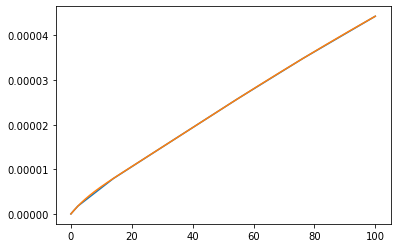

In [92]:
# Run the model with the voltage fixed at -80mV and compare with the analytic solution obtained using an
# equivalent two gate model. This equivalence is explained on p.150 of Keener and Sneyd's Mathematical Physiology


#Get the transition rates of the model
[k1, k2, k3, k4] = model.getTransitionRates()

#Use the initial conditions to set C1 and C2 assuming x1,x2 = 0 (equivalently, [C] = 1).
C1 = -k1/(k1+k2)
C2 = -k3/(k3+k4)

# Calculate the current at time t analytically
t = np.linspace(0, 100, 10000)
x1 = C1*np.exp(t*(-k1-k2)) + k1/(k1+k2)
x2 = C2*np.exp(t*(-k3-k4)) + k3/(k3+k4)

# Run the model numerically
numerical_model = ChannelModel(params, lambda t : -80)
ic = [1,0,0]
solution = integrate.solve_ivp(model.getDerivatives, [0,t[-1]], ic)
y = solution.y

# Plot the two solutions 
plt.plot(solution.t, y[0,:])
plt.plot(t, (1-x1)*(1-x2))
plt.xlabel("time /s")
plt.title("Comparison of numerical and two-gate analytic solution")
plt.legend(["Numerical [O]", "Analytic [O]"])

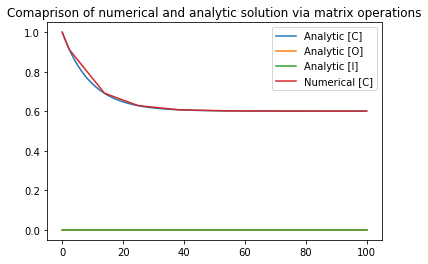

[0.6009675695449815, 4.431498327817993e-05, 2.941897177158289e-05]


In [93]:
# Solve this system using matrix operations with V fixed at -80
model = ChannelModel(params, lambda t: -80)
A, B = model.getSystemOfOdes()

#Solve non-homogeous part
X2 = -np.linalg.inv(A)*B
# Solve the homogenous part
eigenvalues, C = np.linalg.eig(A)
D = np.diag(eigenvalues)

# Let K be the vector of constants from the system dZ/dt = D Z
# where X = CKZ and K is a diagonal matrix of constants and D is a diagonal matrix
# with elements in the order given by linalg.eig(A) 
# Then Z = (e^{-D_i,i})_i and X=CKZ is the general homogenous solution to the system
# dX/dt = AX because dX/dt = CdZ/dt = CDZ = CC^-1ACZ = ACZ = AX

IC = np.matrix([1,0,0]).T
KZ = np.linalg.inv(C)*(IC - X2)
K = np.matrix(np.diag([KZ[i,0] / 1 for i in range(0,3)]))

# Then the full solution is X = CKZ + E

tvec = np.linspace(0,100,1000)
X=[]
for t in tvec:
    Z = np.matrix([np.exp(t*eigenvalues[i]) for i in range(0,3)]).T
    X.append(np.matrix.tolist((C*K*Z + X2).T)[0])

plt.plot(tvec, X)
plt.plot(solution.t, solution.y[0])
plt.legend(["Analytic [C]", "Analytic [O]", "Analytic [I]", "Numerical [C]"])
plt.title("Comaprison of numerical and analytic solution via matrix operations")
plt.show()
print(X[-1])



## 